In [1]:
# Importing the required modules and packages

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("songs_normalize.csv")

In [3]:
# Preparing df for the questions

m = (df["year"] >= 2000) & (df["year"] <= 2019)  # mask that exludes all the songs not released in the 2000-2019 period
df = df[m]                                       # applying the mask

# Function that formats the "duration_ms" values in "{m}:{ss}" strings (used in multiple plots)
#  value: value of the tick
#  position: position of the tick
def to_mss(value, position):
    seconds = int( (value//1000)%60 )
    minutes = int( (value//1000)//60 )
    return f"{minutes}:{seconds:02d}"  # :02d allows to display two digits even if the number has only one (ex. "0" -> "00")

In [4]:
# Preparing the datasets for question 2

# ========================================
## Part 1: number of songs per year

tpy = df.groupby("year", as_index=False)["song"].count()  # Tracks Per Year
tpy = tpy.rename(columns={"song":"n_tracks"})             # renaming the columns so that it has a significant name

# ========================================
## Part 2: get the mean values per year and explicit text

mvpy = df.groupby(["year", "explicit"]).aggregate( {"duration_ms" : "mean",   # Mean Values Per Year
                                                         "danceability" : "mean", 
                                                         "energy" : "mean", 
                                                         "valence": "mean",
                                                         "tempo" : "mean" } ).reset_index()

In [5]:
# Preparing the datasets for question 3

df_copy = df.copy()                 # copying the original DataFrame (songs_nomalize.csv)
df_copy.reset_index(inplace=True)   # adding a column named "index" to df_copy as a DataFrame column


# ========================================
## Part 1: creating a new DataFrame that stores the id of a song and each genre it is classified in in a distinct row

df_genres = pd.DataFrame(columns=["id_track", "genre"])  # the new DataFrame has only 2 columns: "id_track" and "genre"

### Creating a function that finds id and genres of the given row (the row must be a spotify track)
def get_genres(row):
    i = row['index']                      # index of the song
    genres = row['genre'].split(', ')     # list of genres (taken from the "genre" column of df)
    for g in genres:
        df_genres.loc[len(df_genres)] = [i, g.strip()]  # a new row of df_genres is assgined with an [index_of_the_song, genre_of_the_song] object

### Applying the function to every row in df
df_copy.apply( get_genres , axis=1 )    # axis=1 means the function "get_genres" is applied on the rows of df_copy

# ========================================
## Part 2: creating a new DataFrame that shows the number of tracks per genre

tpg = df_genres.groupby("genre", as_index=False).size()  # Tracks Per Genre
tpg = tpg.rename(columns={"size" : "n_tracks"})          # renaming the column "size" in "n_tracks" (more significant)
tpg = tpg.sort_values(by="n_tracks", ascending=False)    # sort the rows in descending order

#========================================
## Part 3: creation of a df containing only the songs of the top-4 genres

columns = ["explicit", "duration_ms", "danceability", "energy", "valence", "tempo", "genre_y"]  # columns to select for each DataFrame

# Series containing the top-4 most popular genres
most_popular_genres = tpg.head(4)["genre"]
m_genre = df_genres["genre"].isin(most_popular_genres)

mvpg = pd.merge(df_copy, df_genres[m_genre], left_on="index", right_on="id_track")[columns]

In [6]:
# Preparing the datasets for question 4

df_copy = df.copy()  # copying the original DataFrame (songs_nomalize.csv)

# Map used to convert the values in the "key" column into the string representatio of the key (ex. D#, E, F...) (more comprehensible)
key_map_array = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
# Map used to convert the 0 and 1 values in the "mode" column into "Minor" and "Major" strings (more comprehensible)
mode_map_array = ["Minor", "Major"]

df_copy["key"] = df_copy["key"].apply(lambda x: key_map_array[x])     # converting "key"
df_copy["mode"] = df_copy["mode"].apply(lambda x: mode_map_array[x])  # converting "mode"

# Pivot-table dataset that shows the number of songs for each combination of key and mode
spkm = df_copy.pivot_table(values="song", index="mode", columns="key", aggfunc="count")  # Songs Per Key, Mode

## DataFrame that shows some stats for valence (used in second part of the question)
mode_stats = df_copy.groupby(["mode"]).aggregate({"valence" : ["count", "median", "mean", "std", "min", "max"]})

#### Joshua Rumiato - 168062
#### Università degli Studi di Udine - A.A. 2023/2024

# Analisi sui dati delle maggiori hit su Spotify del periodo 2000-2019
---

In [7]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

## Perché analizzare le canzoni?

* La passione per la musica
* Il desiderio di scoprire pattern e tendenze
* L'importanza di Spotify nel panorama musicale moderno

## Il dataset

### Informazioni generali

* Nome: Top Hits Spotify from 2000-2019
* Disponibile su Kaggle a [questo indirizzo](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019)
* Creato da [Mark Koverha](https://www.kaggle.com/paradisejoy) e aggiornato l'ultima volta 2 anni fa

### Dati rilevanti

* Generalità dei brani (artista, titolo, anno di pubblicazione, durata)
* Contrassegno di testo esplicito
* Tonalità (colonne *key* e *mode*)
* Metriche *danceability*, *energy*, *valence*
* BPM e generi
<br/>
<br/>
### Dati interessanti ma non presenti

* Tipologia di canzone (singolo o traccia di un album)
* Numero di stream di ciascuna traccia
* Tipo e numero di playlist in cui è inserita ogni canzone

## Domande

1. È possibile definire una relazione tra i valori di *danceability*, *energy* e *valence*?
2. Come sono mutati i parametri principali di una canzone nel corso degli anni?
3. Ci sono differenze rilevanti fra i generi di maggior successo?
4. Quali sono le tonalità maggiormente utilizzate per comporre una canzone?

## 1. È possibile definire una relazione tra i valori di danceability, energy e valence?

Tutti e tre le metriche si esprimono con una misura da 0.000 a 1.000. Campiamo cosa indicano:
* **Danceability**: adeguatezza di un brano per ballare.
* **Energy**: misura percettiva dell'intensità e dell'attività di un pezzo.
* **Valence**: positività musicale di una traccia.

Calcoliamo i coefficienti di correlazione di Pearson, Spearman e Kendall per ciascuna coppia di colonne

### Correlazione tra *danceability* e *energy*

In [8]:
# Pearson correlation coeff. between "danceability" and "energy"
corr_pearson = sp.stats.pearsonr(df["danceability"], df["energy"])
print(f"Pearson:  {corr_pearson[0]}  |  p={corr_pearson[1]}")

# Spearman correlation coeff. between "danceability" and "energy"
corr_spearman = sp.stats.spearmanr(df["danceability"], df["energy"])
print(f"Spearman: {corr_spearman[0]}  |  p={corr_spearman[1]}")

# Kendall correlation coeff. between "danceability" and "energy"
corr_kendall = sp.stats.kendalltau(df["danceability"], df["energy"])
print(f"Kendall:  {corr_kendall[0]}  |  p={corr_kendall[1]}")

Pearson:  -0.10858432616007851  |  p=1.4649615773210632e-06
Spearman: -0.16242654636620862  |  p=4.803850446471279e-13
Kendall:  -0.11089066260082832  |  p=2.1551324295744103e-13


### Correlazione tra *danceability* e *valence*

In [9]:
# Pearson correlation coeff. between "danceability" and "valence"
corr_pearson = sp.stats.pearsonr(df["danceability"], df["valence"])
print(f"Pearson:  {corr_pearson[0]} |  p={corr_pearson[1]}")

# Spearman correlation coeff. between "danceability" and "valence"
corr_spearman = sp.stats.spearmanr(df["danceability"], df["valence"])
print(f"Spearman: {corr_spearman[0]}  |  p={corr_spearman[1]}")

# Kendall correlation coeff. between "danceability" and "valence"
corr_kendall = sp.stats.kendalltau(df["danceability"], df["valence"])
print(f"Kendall:  {corr_kendall[0]}  |  p={corr_kendall[1]}")

Pearson:  0.39922841064796055 |  p=8.140702106744315e-76
Spearman: 0.3954525959719468  |  p=2.6801923248303464e-74
Kendall:  0.2702370585478343  |  p=1.392672113945779e-71


### Correlazione tra *energy* e *valence*

In [10]:
# Pearson correlation coeff. between "energy" and "valence"
corr_pearson = sp.stats.pearsonr(df["energy"], df["valence"])
print(f"Pearson:  {corr_pearson[0]}  |  p={corr_pearson[1]}")

# Spearman correlation coeff. between "energy" and "valence"
corr_spearman = sp.stats.spearmanr(df["energy"], df["valence"])
print(f"Spearman: {corr_spearman[0]}    |  p={corr_spearman[1]}")

# Kendall correlation coeff. between "energy" and "valence"
corr_kendall = sp.stats.kendalltau(df["energy"], df["valence"])
print(f"Kendall:  {corr_kendall[0]}   |  p={corr_kendall[1]}")

Pearson:  0.33392469652015166  |  p=3.2737401174661917e-52
Spearman: 0.306081844255608    |  p=9.69963737024036e-44
Kendall:  0.2069063355680458   |  p=1.0324336839531779e-42


### Osservazioni

Si registrano valori di *p* molto bassi: tutte le correlazioni hanno bassa probabilità che siano dovute al caso.
Nello specifico si osserva:

* *danceability*-*energy*: correlazione negativa molto debole
* *danceability*-*valence*: correlazione positiva moderata (in particolare il coefficiente di Pearson)
* *energy*-*valence*: correlazione positiva moderata (leggermente meno rispetto alla precedente)

Complessivamente, non si notano correlazioni particolarmente forti.

## 2. Come sono mutati i parametri principali di una canzone nel corso degli anni?

Visualizziamo quante canzoni sono presenti nel dataset, suddivise per anno, nel periodo 2000-2019:

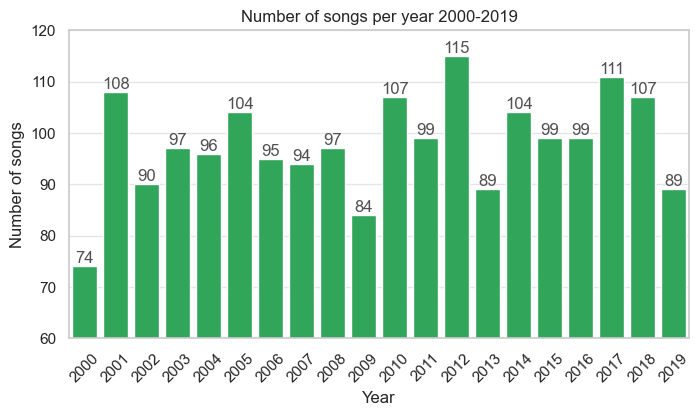

In [11]:
sns.set_theme(style="whitegrid")   # setting the plots theme
plt.figure(figsize=(8,4))          # defining a new figure with dimentions 8x4
ax = sns.barplot(data=tpy, x="year", y="n_tracks", color="#1DB954")
ax.set(title="Number of songs per year 2000-2019", xlabel="Year", ylabel="Number of songs", ylim=[60, 120])
ax.grid(axis="y", alpha=.5)        # showing the grid only for y-axis and setting the transparency
plt.xticks(rotation=45)            # rotating 45° the ticks on x-axis to make them more clear

for p in ax.patches:   # ax.patches is the list of shapes (in this case rectangles) in the plot
    ax.text(x= p.get_x() + p.get_width() / 2,           # setting x-coord. of the text
            y= p.get_height(),                          # setting y-coord. of the text
            s= f'{int(p.get_height())}',                # setting the value of the text
            ha='center', va='bottom', color="#505050")  # setting additional parameters

### Andamento della durata media delle canzoni negli anni

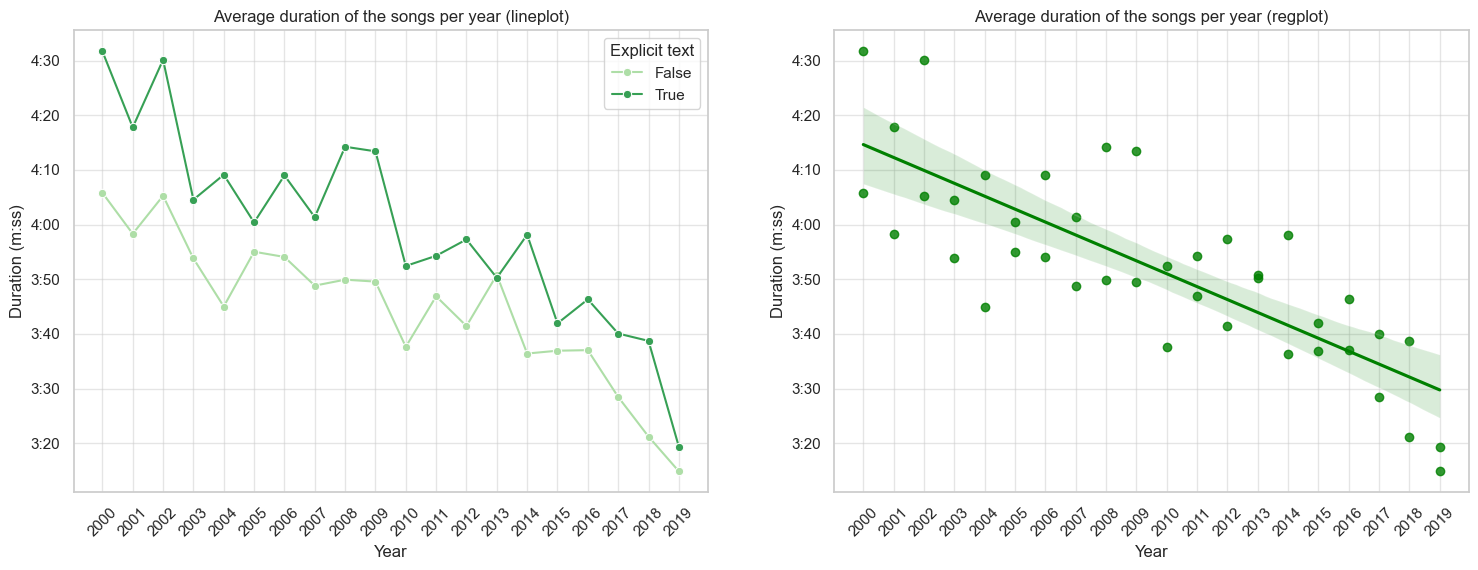

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # creating a figure containing 2 plots

# Creazione del lineplot
sns.lineplot(data=mvpy, x="year", y="duration_ms", hue="explicit", marker="o", palette="Greens", ax=axes[0])
sns.regplot(data=mvpy, x="year", y="duration_ms", color="green", ax=axes[1])


axes[0].set_title("Average duration of the songs per year (lineplot)")
axes[0].legend(title="Explicit text")
axes[1].set_title("Average duration of the songs per year (regplot)")

for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Duration (m:ss)")
    ax.grid(alpha=0.5)
    ax.set_xticks(mvpy["year"][::2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)    # setting x-axis ticks labels
    ax.yaxis.set_major_formatter(plt.FuncFormatter(to_mss))  # formatting the ticks on y-axis

**Osservazione:** la durata media delle canzoni è in calo

### Andamento della *valence* media negli anni

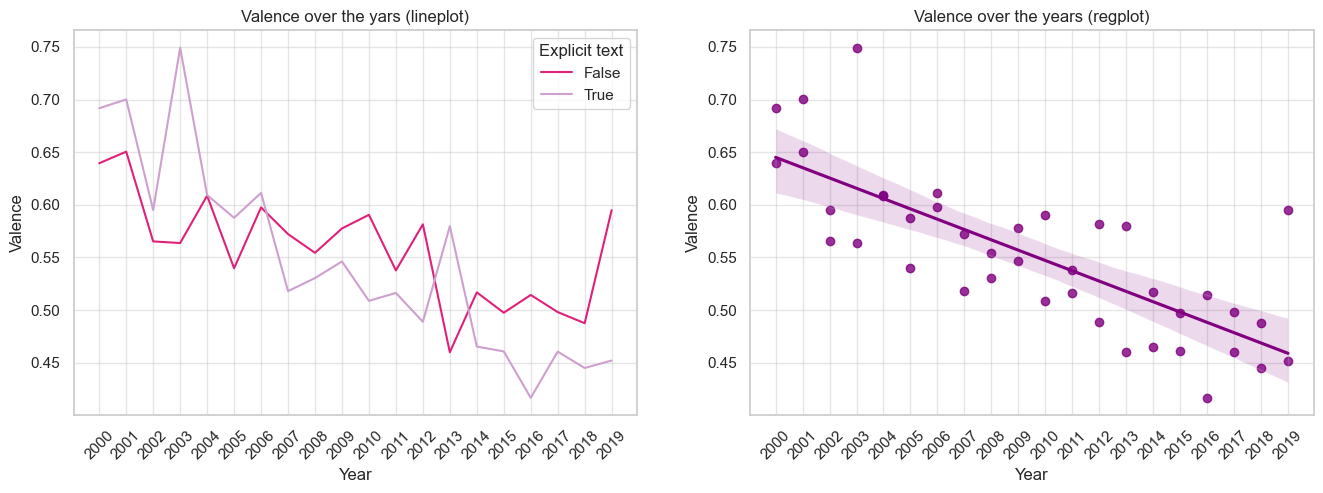

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(data=mvpy, x="year", y="valence", hue="explicit", palette="PuRd_r", ax=axes[0])
sns.regplot(data=mvpy, x="year", y="valence", color="Purple", ax=axes[1])

# Impostazioni dei titoli e delle etichette
axes[0].set_title("Valence over the yars (lineplot)")
axes[1].set_title("Valence over the years (regplot)")

axes[0].legend(title="Explicit text")

for ax in axes:
    ax.set(xlabel="Year", ylabel="Valence")
    ax.grid(alpha=0.5)
    ax.set_xticks(mvpy["year"][::2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

**Osservazione:** la *valence* delle canzoni è in calo

### Andamento degli altri parametri

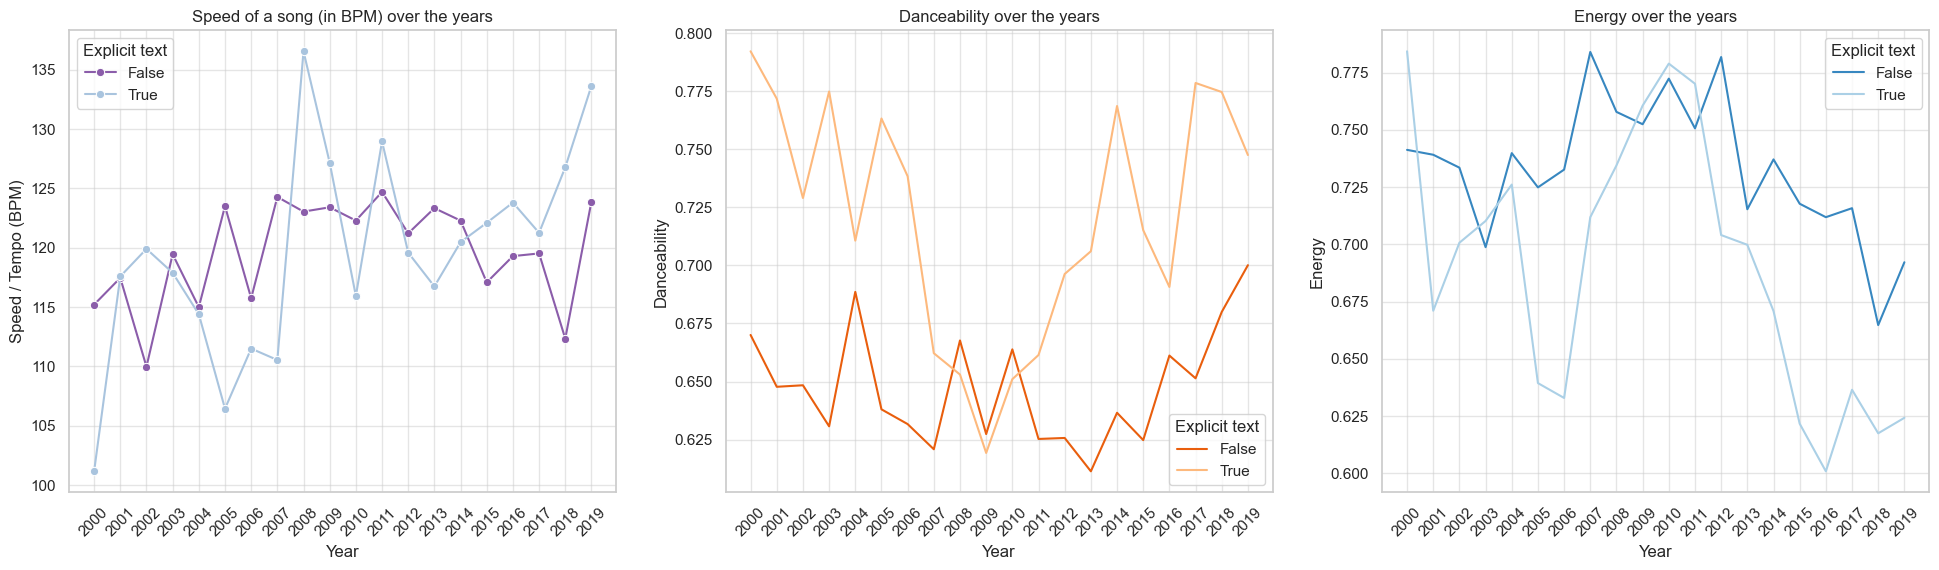

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # creating a figure containing 3 plots

sns.lineplot(data=mvpy, x="year", y="tempo", hue="explicit", marker="o", palette="BuPu_r", ax=axes[0])
axes[0].set(title="Speed of a song (in BPM) over the years", xlabel="Year", ylabel="Speed / Tempo (BPM)")

sns.lineplot(data=mvpy, x="year", y="danceability", hue="explicit", palette="Oranges_r", ax=axes[1])
axes[1].set(title="Danceability over the years", xlabel="Year", ylabel="Danceability")


sns.lineplot(data=mvpy, x="year", y="energy", hue="explicit", palette="Blues_r", ax=axes[2])
axes[2].set(title="Energy over the years", xlabel="Year", ylabel="Energy")

for ax in axes:
    ax.grid(alpha=0.5)
    ax.legend(title="Explicit text")
    ax.set_xticks(mvpy["year"][::2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # setting x-axis ticks labels

Non si osservano tendenze chiare, i valori variano molto in funzione dell'anno e del tipo di testo

## 3. Ci sono differenze rilevanti fra i generi di maggior successo?

Mostriamo quali sono i generi che hanno avuto più successo nel periodo 2000-2019:

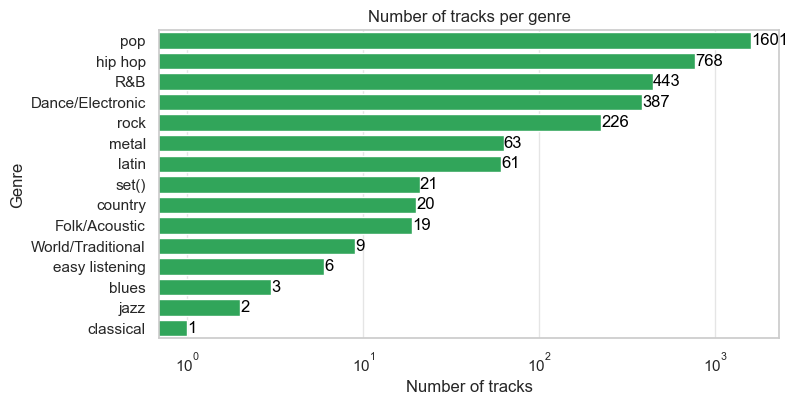

In [16]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=tpg, x="n_tracks", y="genre", color="#1DB954")
ax.set(title="Number of tracks per genre", xlabel="Number of tracks", ylabel="Genre", xscale="log")
ax.grid(axis="x", alpha=.5)

# Adding labels
for index, value in enumerate(tpg["n_tracks"]):
    ax.text(x= value, 
            y= index,
            s= str(value),
            color='black', ha="left", va="center")

### Distribuzione della velocità delle canzoni per genere

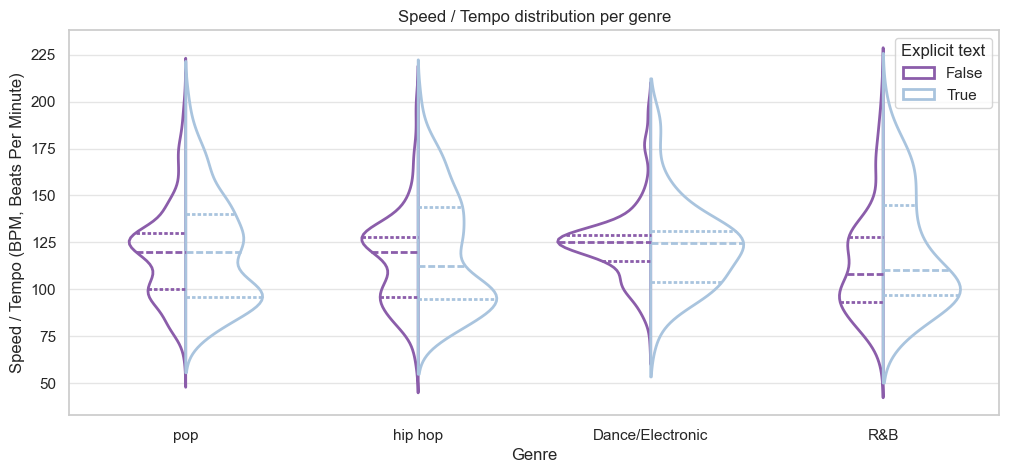

In [17]:
plt.figure(figsize=(12,5))
ax = sns.violinplot(data=mvpg, x='genre_y', y='tempo', hue="explicit", palette="BuPu_r", fill=False, split=True, inner="quart", linewidth=2)
ax.set(title="Speed / Tempo distribution per genre", xlabel="Genre", ylabel="Speed / Tempo (BPM, Beats Per Minute)")
ax.legend(title="Explicit text")
ax.grid(axis="y", alpha=0.5)

**Osservazione:** le distribuzioni delle velocità non sono uniformi; le canzoni R&B sono normalmente più lente rispetto a quelle degli altri generi analizzati

### Distribuzione della *danceability* per genere

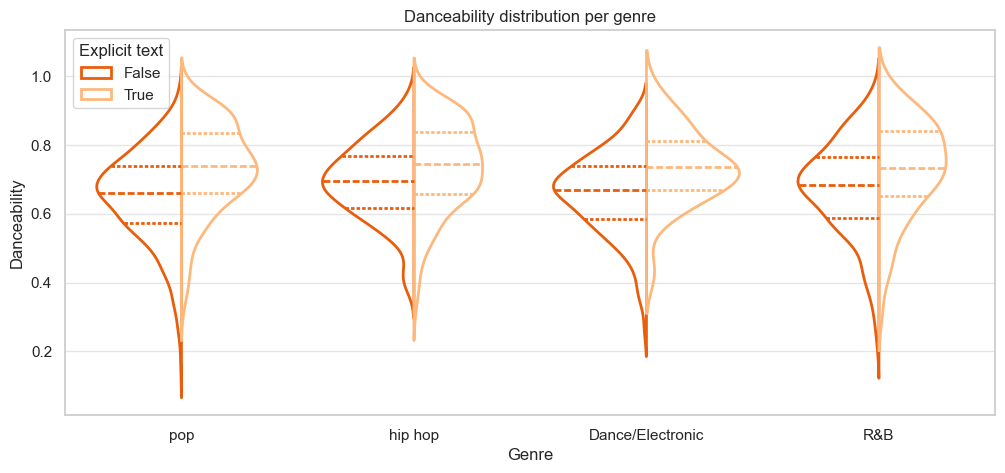

In [18]:
plt.figure(figsize=(12,5))
ax = sns.violinplot(data=mvpg, x='genre_y', y='danceability', hue="explicit", palette="Oranges_r", fill=False, split=True, inner="quart", linewidth=2)
ax.set(title="Danceability distribution per genre", xlabel="Genre", ylabel="Danceability")
ax.legend(title="Explicit text")
ax.grid(axis="y", alpha=0.5)

**Osservazione:** per ogni genere, le canzoni *explicit* hanno valori di *danceabiltiy* più alti

### Distribuzione di *energy* per genere

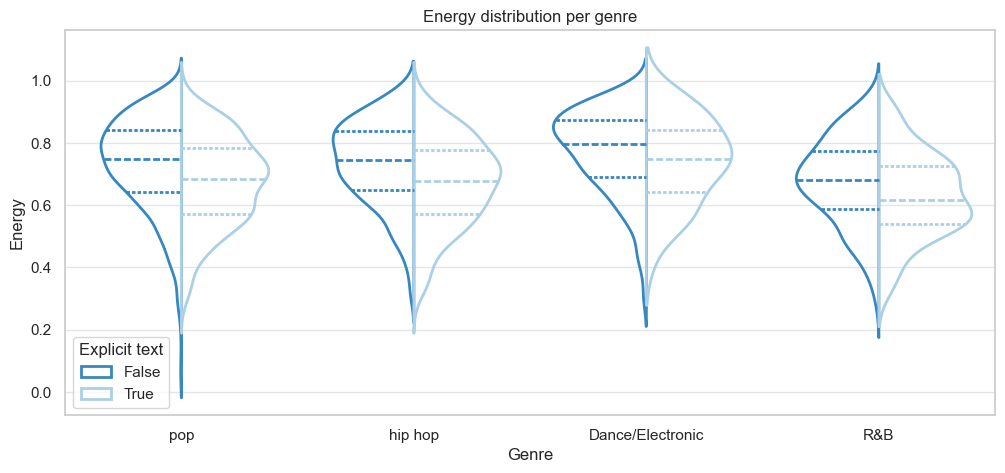

In [19]:
plt.figure(figsize=(12,5))
ax = sns.violinplot(data=mvpg, x='genre_y', y='energy', hue="explicit", palette="Blues_r", fill=False, split=True, inner="quart", linewidth=2)
ax.set(title="Energy distribution per genre", xlabel="Genre", ylabel="Energy")
ax.legend(title="Explicit text")
ax.grid(axis="y", alpha=0.5)

**Osservazione:** per ogni genere, le canzoni *explicit* hanno valori di *energy* più bassi

### Distribuzione degli altri parametri per genere

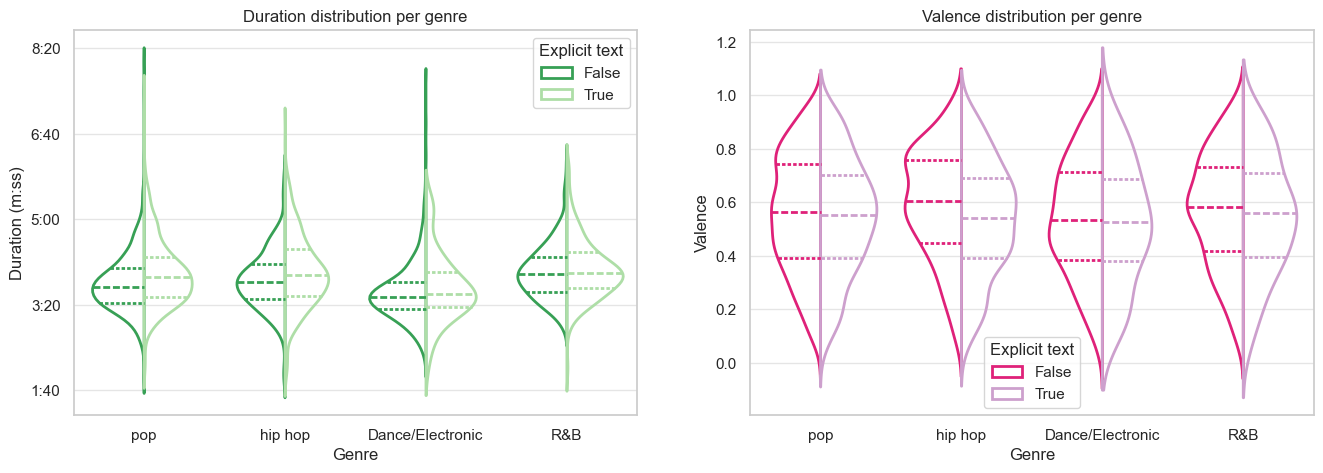

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # creating a figure containing 3 plots

sns.violinplot(ax=axes[0], data=mvpg, x='genre_y', y='duration_ms', hue="explicit", palette="Greens_r", fill=False, split=True, inner="quart", linewidth=2)
axes[0].set(title="Duration distribution per genre", xlabel="Genre", ylabel="Duration (m:ss)")
axes[0].legend(title="Explicit text")
axes[0].grid(axis="y", alpha=0.5)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(to_mss))  # formatting the ticks on y-axis

sns.violinplot(ax=axes[1], data=mvpg, x='genre_y', y='valence', hue="explicit", palette="PuRd_r", fill=False, split=True, inner="quart", linewidth=2)
axes[1].set(title="Valence distribution per genre", xlabel="Genre", ylabel="Valence")
axes[1].legend(title="Explicit text")
axes[1].grid(axis="y", alpha=0.5)

## 4. Quali sono le tonalità maggiormente utilizzate per comporre una canzone?

Nella teoria musicale, la tonalità è cruciale nella struttura di un brano. *Key* e *mode* indicano la tonalità di una canzone nel dataset. 
* **Key**: identifica la nota principale dell'accordo (detta tonica)
* **Mode**: distingue una tonalità tra *maggiore* e *minore*, caratterizzando un pezzo da un punto di vista emotivo
  - *Maggiore*: tende ad evocare emozioni più felici
  - *Minore*: dà alla canzone un tono più cupo e malinconico

Visualizziamo il grafico:

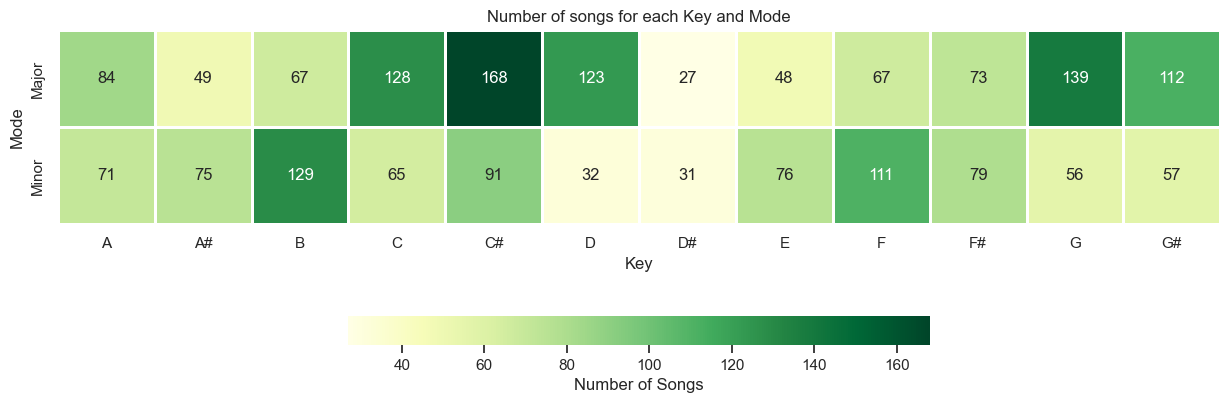

In [21]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(data=spkm, square=True, linewidths=1, cmap="YlGn", cbar_kws={'label': 'Number of Songs', "shrink" : .5, "location": "bottom"}, fmt="d" , annot=True)
ax.set(title="Number of songs for each Key and Mode", xlabel="Key", ylabel="Mode");

### I dati confermano quanto introdotto precedentemente?

Analizziamo le differenze tra scale *maggiori* e *minori* sotto il punto di vista della *valence*:

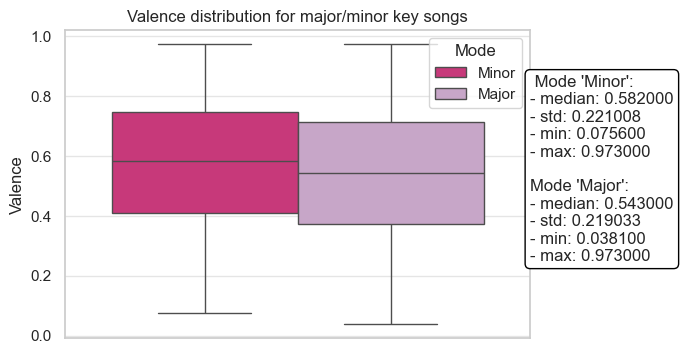

In [22]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df_copy, y="valence", hue="mode", palette="PuRd_r")
ax.set(title="Valence distribution for major/minor key songs", ylabel="Valence");
ax.grid(axis="y", alpha=0.5)
ax.legend(title="Mode");

desc = f""" Mode 'Minor':
- median: {mode_stats["valence", "median"]["Minor"]:0f}
- std: {mode_stats["valence", "std"]["Minor"]:0f}
- min: {mode_stats["valence", "min"]["Minor"]:0f}
- max: {mode_stats["valence", "max"]["Minor"]:0f}

Mode 'Major':
- median: {mode_stats["valence", "median"]["Major"]:0f}
- std: {mode_stats["valence", "std"]["Major"]:0f}
- min: {mode_stats["valence", "min"]["Major"]:0f}
- max: {mode_stats["valence", "max"]["Major"]:0f}"""

ax.annotate(text=desc, xy=(0.5, 0.25), xycoords="data", textcoords="data",
           bbox={"boxstyle" : "round,pad=0.3", "edgecolor" : "black", "facecolor" : "w"});

La differenza tra *mode* "Major" e "Minor" in termini di *valence* è minima.
Le canzoni in tonalità minore hanno addirttura valori di mediana e dev. standard leggermente più alti

## Conclusioni
### Quali sono i risultati delle analisi?

* Assenza di correlazioni forti tra *danceability*, *energy* e *valence*
* Le canzoni durano sempre meno
* Negli ultimi anni *valence* è in calo e si attesta su valori intermedi
* Tutte le maggiori hit condividono aspetti in manierà più o meno marcata (la distribuzione dei parametri per genere è simile)
* Tonalità più utilizzata: *Do# maggiore*
* La differenza di tonalità (dalla teoria musciale) non trova riscontro in termini di differenza fra *valence* dei brani

To convert to slides:

python -m nbconvert definitivo.ipynb --to slides --no-input --SlidesExporter.reveal_number='c/t' --SlidesExporter.reveal_scroll=True